# Analysing a Hipothetic Market Competition Environment

## Problem description

This project aims to evaluate an usual market situation where a set of products provided by several competitors generates many demand curves, depending on the prices and payment benefits offered by each one.

In 2 (two) files, we can observe:

- The quantities sold by our company, per day and price practiced, from 2015 1st Jan to 2015 14th Oct;
- The competitors's prices and payment types practiced, monitored per time (day-in), on the same dates;

There are 6 (six) competitors (C1 to C6), 9 (nine) products (P1 to P9) and 2 (two) payment types (T1: deferred payment and T2: immediate payment).

Our goals here are:

1) Produce an understanding of prices, payment methods and demand behavior; and

2) Purpose a machine learning schema to predict demanda in quantities given the prices set

## Problem solving

### There are 4 (four) stages to perform:

1) Data Preparation: We will stratify and clean the data and join the datasets, preparing them for machine learning aplication; 

2) Exploratory Analysis: We will analyze internal sales and prices data in order to understand our most importants products, sales volatility and prices distribution on market;

3) Correlation Analysis: We will build the base to be used in the machine learning process and use it to study the correlations between the features;

4) Machine Learning: We will perform features selection and test 5 (five) regressor algorithms to predict demanda in quantities given all the prices and payment types, per each product. 

## Data Preparation

In [1]:
# Import modules

# Data handling
import pandas as pd
import numpy as np

# Date and time handling
import datetime as dt

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Statistics packages (for linear regression)
from scipy import stats

# Warnings setting
import warnings
warnings.filterwarnings('ignore')

# Machine learning packages
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

### First view on data

1) Internal sales: in 'df_sales' dataframe; contains 4 features and 351,091 sales registers, on 287 days

2) Competitors: in 'df_comp' dataframe; contains 5 features and 50,114 prices and payment methods registers, on 287 days, detailed by time (hour/minute/second) monitored 

In [2]:
# Import files int dataframes
df_sales = pd.read_csv("test_prc/sales.csv", sep=',', parse_dates=['DATE_ORDER'])
df_comp = pd.read_csv("test_prc/comp_prices.csv", sep=',', parse_dates=['DATE_EXTRACTION'])

# Report
print("df_sales ", "\n\nlines: %.d"%(df_sales.shape[0]), "features: %.d"%(df_sales.shape[1]),
      "\n\n", df_sales.ftypes, "\n\n", df_sales.head(2),
      "\n\n\n **************************************\n\n", 
      "df_comp", "\n\nlines: %.d"%(df_comp.shape[0]), "features: %.d"%(df_comp.shape[1]),
      "\n\n", df_comp.ftypes, "\n\n", df_comp.head(2))

df_sales  

lines: 351091 features: 4 

 PROD_ID               object:dense
DATE_ORDER    datetime64[ns]:dense
QTY_ORDER            float64:dense
REVENUE              float64:dense
dtype: object 

   PROD_ID DATE_ORDER  QTY_ORDER  REVENUE
0      P6 2015-08-02        1.0  1808.99
1      P6 2015-08-17        1.0  1674.00 


 **************************************

 df_comp 

lines: 50114 features: 5 

 PROD_ID                     object:dense
DATE_EXTRACTION     datetime64[ns]:dense
COMPETITOR                  object:dense
COMPETITOR_PRICE           float64:dense
PAY_TYPE                     int64:dense
dtype: object 

   PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE
0      P6 2015-01-30 08:11:38         C3            1898.0         1
1      P6 2015-01-30 08:11:38         C1            1898.0         1


### Data Handling

On df_sales:

- Create a column for average price (Revenue / QTY_ORDER);
- Create columns for month and year

On df_comp:

- Create a column for date;
- Eliminate a line with error (DATE_EXTRACTION 2019-10-14 08:11:39): Prices were multiplied by 100

In [3]:
# df_sales updates
df_sales['PRICE'] = df_sales.apply(lambda x: 0 if x.QTY_ORDER==0 else x.REVENUE/x.QTY_ORDER, axis=1)
df_sales['MONTH'] = df_sales['DATE_ORDER'].dt.month
df_sales['YEAR'] = df_sales['DATE_ORDER'].dt.year

# df_comp updates
df_comp['DATE'] = df_comp['DATE_EXTRACTION'].dt.date
df_comp['DATE'] = pd.to_datetime(df_comp['DATE'])

# Cleaning df_comp from a line with error on loading
df_comp = df_comp[df_comp['DATE_EXTRACTION'] != dt.datetime(2015,10,14,8,11,39)]

## Exploratory Analysis

### Analysing Revenue

1) Participation: the most importants are products P7 and P2, although produtcs P5, P8 and P9 had increased their shares since July;

2) Volatility: there are strongs oscilations on revenue per day, observing the curves format and the product's standard deviations and means obtained;

PROD_ID,P1,P2,P3,P4,P5,P6,P7,P8,P9
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,20.955041,160.339670,12.941359,29.465848,55.427304,24.667316,561.819309,42.361256,27.801051
std,18.003083,286.420897,14.304555,69.463598,130.190930,61.929743,509.050300,85.479538,57.324832
min,0.000000,5.574220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.132525,37.380025,3.729290,0.000000,0.000000,7.302880,220.885900,0.000000,0.000000
50%,17.388000,62.871460,8.559290,7.172650,4.009930,14.117540,439.741820,14.033380,8.098200
75%,27.868660,124.301250,18.076445,26.464100,25.751550,21.508825,666.923150,36.366840,22.027330
max,107.330480,2419.697840,125.466300,636.063800,1033.152980,604.466830,3713.717320,674.246670,357.193840


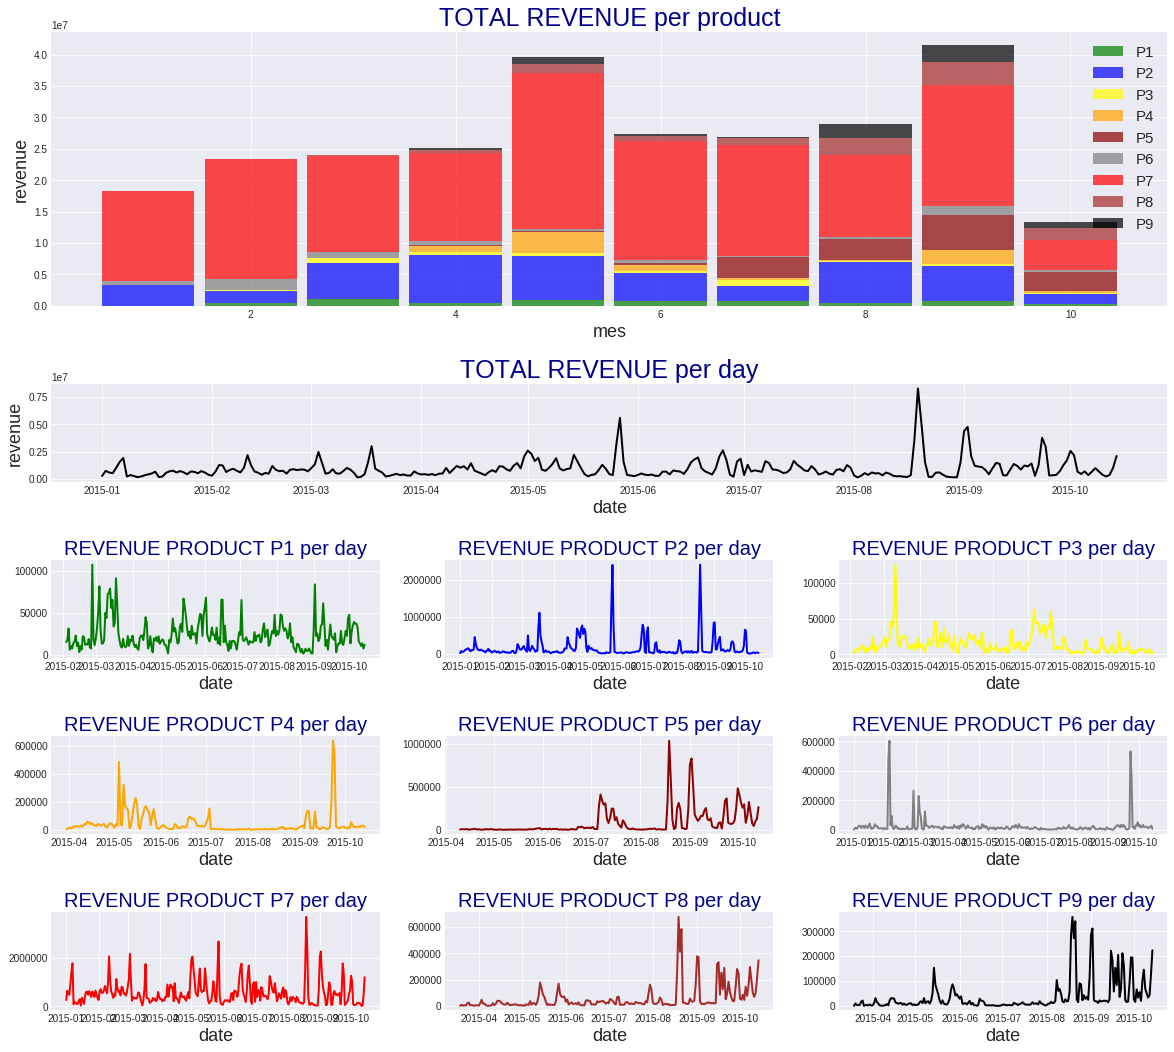

In [4]:
# Revenue Analysis Plotting

# Style setting
plt.style.use('seaborn-darkgrid') # style

# Grid building
fig = plt.figure(figsize=(20,18))

gs = mpl.gridspec.GridSpec(6,3, wspace=0.2, hspace=0.8)
axst = plt.subplot(gs[:2,:])
axli = plt.subplot(gs[2, :])
ax1 = plt.subplot(gs[3, :-2])
ax2 = plt.subplot(gs[3, 1:-1])
ax3 = plt.subplot(gs[3, 2])
ax4 = plt.subplot(gs[4, :-2])
ax5 = plt.subplot(gs[4, 1:-1])
ax6 = plt.subplot(gs[4, 2])
ax7 = plt.subplot(gs[5, :-2])
ax8 = plt.subplot(gs[5, 1:-1])
ax9 = plt.subplot(gs[5, 2])

# Parameters
prod = list(range(1,10))
ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
colors = ['green','blue','yellow','orange','darkred','grey','red','brown','black']

# Stacked Bar Plot
dados = df_sales.pivot_table(
    index=['MONTH'], columns='PROD_ID', values='REVENUE',aggfunc='sum').fillna(0)

bar_labels = list(dados.index)
Width = 0.9

P1_bar = axst.bar(bar_labels, dados['P1'],width=Width, align='center',color=colors[0],alpha=0.7)
P2_bar = axst.bar(bar_labels, dados['P2'],width=Width, align='center',color=colors[1],alpha=0.7,
                bottom=dados['P1'])
P3_bar = axst.bar(bar_labels, dados['P3'],width=Width, align='center',color=colors[2],alpha=0.7,
                bottom=dados['P1']+dados['P2'])
P4_bar = axst.bar(bar_labels, dados['P4'],width=Width, align='center',color=colors[3],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3'])
P5_bar = axst.bar(bar_labels, dados['P5'],width=Width, align='center',color=colors[4],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3']+dados['P4'])
P6_bar = axst.bar(bar_labels, dados['P6'],width=Width, align='center',color=colors[5],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3']+dados['P4']+dados['P5'])
P7_bar = axst.bar(bar_labels, dados['P7'],width=Width, align='center',color=colors[6],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3']+dados['P4']+dados['P5']+dados['P6'])
P8_bar = axst.bar(bar_labels, dados['P8'],width=Width, align='center',color=colors[7],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3']+dados['P4']+dados['P5']+dados['P6']+dados['P7'])
P9_bar = axst.bar(bar_labels, dados['P9'],width=Width, align='center',color=colors[8],alpha=0.7,
                bottom=dados['P1']+dados['P2']+dados['P3']+dados['P4']+dados['P5']+dados['P6']+dados['P7']+
                dados['P8'])

axst.set_title("TOTAL REVENUE per product", fontsize=25, color='darkblue')
axst.set_xlabel("mes",fontsize=18)
axst.set_ylabel("revenue", fontsize=18)
axst.legend(list(dados.columns), fontsize=15)

# Line Plot - Total
dados2 = df_sales.pivot_table(index='DATE_ORDER', values='REVENUE', aggfunc='sum').reset_index()
dados2_xtick = np.array(dados2['DATE_ORDER'])
dados2_values = np.array(dados2['REVENUE'])

axli.set_title("TOTAL REVENUE per day", fontsize=25, color='darkblue')
axli.plot_date(x=dados2_xtick,y=dados2_values,color='black',xdate=True,fmt='-',linewidth=2)
axli.set_xlabel("date",fontsize=18)
axli.set_ylabel("revenue", fontsize=18)

# Line Plot - Products
for i in prod:
    
    string = 'P' + str(i)
    k = i-1
    a = ax[k]
    
    dados2 = df_sales[df_sales['PROD_ID']==string].pivot_table(index='DATE_ORDER', 
                                              values='REVENUE', aggfunc='sum').reset_index()
    dados2_xtick = np.array(dados2['DATE_ORDER'])
    dados2_values = np.array(dados2['REVENUE'])

    a.set_title("REVENUE PRODUCT "+string+" per day", fontsize=20, color='darkblue')
    a.plot_date(x=dados2_xtick,y=dados2_values,color=colors[k],xdate=True,fmt='-',linewidth=2)
    a.set_xlabel("date",fontsize=18)

# Sales in revenue - statistics
dados = df_sales.pivot_table(
    index=['DATE_ORDER'], columns='PROD_ID', values='REVENUE',aggfunc='sum').fillna(0).describe()

dados.iloc[1:, :] = dados.iloc[1:, :]/1000
dados

### QTY - Prices dispersion and Linear Elasticity Analysis

Analysing the relation between quantities sold and prices, we observe that it is not linear at all; The R² linear coeficients are very low. 

Observing the dispersion curves, it seems that there are several curves of quantities per price in each product, almost parallel to each other, with only a change on level.

Even so, the tendency on the linear regression is negative, pointing to a well known demand curve concept: sales tend to decrease with price upping.

Total :  linear elasticity (r): -0.016 	 r-squared: 0.000
P1 :  linear elasticity (r): -0.040 	 r-squared: 0.002
P2 :  linear elasticity (r): -0.072 	 r-squared: 0.005
P3 :  linear elasticity (r): -0.053 	 r-squared: 0.003
P4 :  linear elasticity (r): -0.015 	 r-squared: 0.000
P5 :  linear elasticity (r): -0.053 	 r-squared: 0.003
P6 :  linear elasticity (r): -0.034 	 r-squared: 0.001
P7 :  linear elasticity (r): -0.020 	 r-squared: 0.000
P8 :  linear elasticity (r): -0.046 	 r-squared: 0.002
P9 :  linear elasticity (r): -0.044 	 r-squared: 0.002


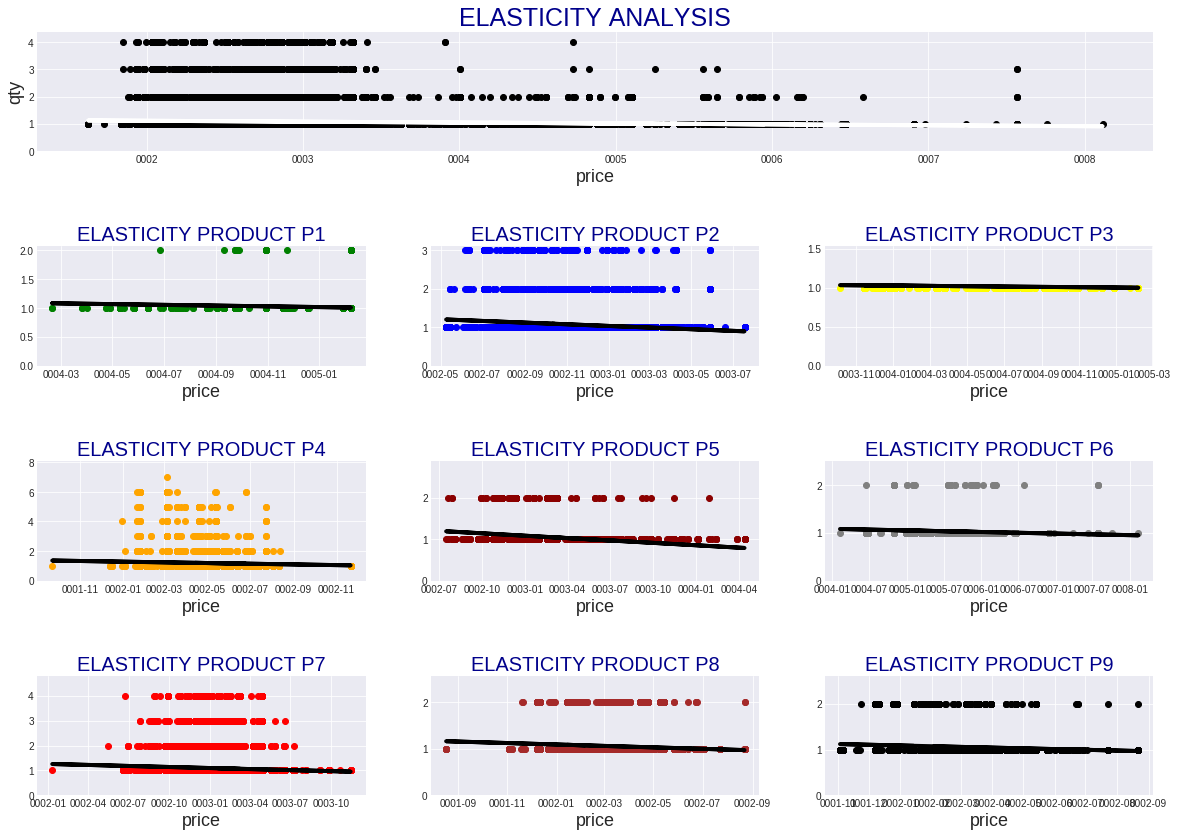

In [5]:
# QTY - Prices Dispersion - Linear Elasticity Analysis

# Style setting
plt.style.use('seaborn-darkgrid') # style

# Grid building
fig = plt.figure(figsize=(20,18))

gs = mpl.gridspec.GridSpec(5,3, wspace=0.2, hspace=0.8)
axli = plt.subplot(gs[1, :])
ax1 = plt.subplot(gs[2, :-2])
ax2 = plt.subplot(gs[2, 1:-1])
ax3 = plt.subplot(gs[2, 2])
ax4 = plt.subplot(gs[3, :-2])
ax5 = plt.subplot(gs[3, 1:-1])
ax6 = plt.subplot(gs[3, 2])
ax7 = plt.subplot(gs[4, :-2])
ax8 = plt.subplot(gs[4, 1:-1])
ax9 = plt.subplot(gs[4, 2])

# Parameters
prod = list(range(1,10))
ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
colors = ['green','blue','yellow','orange','darkred','grey','red','brown','black']


# Line Plot - Total
dados2_xtick = np.array(df_sales['PRICE'])
dados2_values = np.array(df_sales['QTY_ORDER'])
Y_lim = dados2_values.mean() + dados2_values.std()*3

slope, intercept, r_value, p_value, std_err = stats.linregress(dados2_xtick, dados2_values)
y_pred = list(dados2_xtick * slope + intercept)

axli.set_title("ELASTICITY ANALYSIS", fontsize=25, color='darkblue')
axli.plot_date(x=dados2_xtick,y=dados2_values,color='black',fmt='o',linewidth=2)
axli.plot_date(x=dados2_xtick, y=y_pred, color='white', fmt='-',linewidth=4)
axli.set_xlabel("price",fontsize=18)
axli.set_ylabel("qty", fontsize=18)
axli.set_ylim(0, Y_lim)

# Line Plot - Products
pairs = []
pairs.append(("Total", r_value))

for i in prod:
    
    string = 'P' + str(i)
    k = i-1
    a = ax[k]
    
    dados2 = df_sales[df_sales['PROD_ID']==string]
    dados2_xtick = np.array(dados2['PRICE'])
    dados2_values = np.array(dados2['QTY_ORDER'])
    Y_lim = dados2_values.mean() + dados2_values.std()*3
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(dados2_xtick, dados2_values)
    y_pred = list(dados2_xtick * slope + intercept)
    
    a.set_title("ELASTICITY PRODUCT "+string, fontsize=20, color='darkblue')
    a.plot_date(x=dados2_xtick,y=dados2_values,color=colors[k],fmt='o',linewidth=2)
    a.plot_date(x=dados2_xtick, y=y_pred, color='black', fmt='-',linewidth=4)
    a.set_xlabel("price",fontsize=18)
    a.set_ylim(0, Y_lim)
    
    (name, corr) = (string, r_value)
    pairs.append((name, corr))

# Printingo correlarions
dic = dict(pairs)

for i in list(range(len(pairs))):
    print(list(dic.keys())[i], ": ", "linear elasticity (r): %.3f \t r-squared: %.3f"%
          ((list(dic.values())[i]), list(dic.values())[i]**2))
    
plt.show()

###  Prices Distribution on Market

Using boxplots, we can observe that:

- Prices behavior (level and volatility) are very similar amongst the participants, what indicates a balanced market and puts additional pressure on day-by-day pricing;

- Prices behavior do not change so much with the payment method adopted for most of cases (wich does not inply that their sales don't change, we actually have no data on it)

- Prodct P6 has the highest price level and volatility, for all participants;

- Products P8 and P9 are the most cheap; knowing that their share in our sales started growing since July, it indicates that they could be newbies in the market

Important: 

for boxplot, we use only the prices higher than 0 (zero), so the statistics are not compromised. 

To do so, we have to implement an array building code, wich was properly identified.


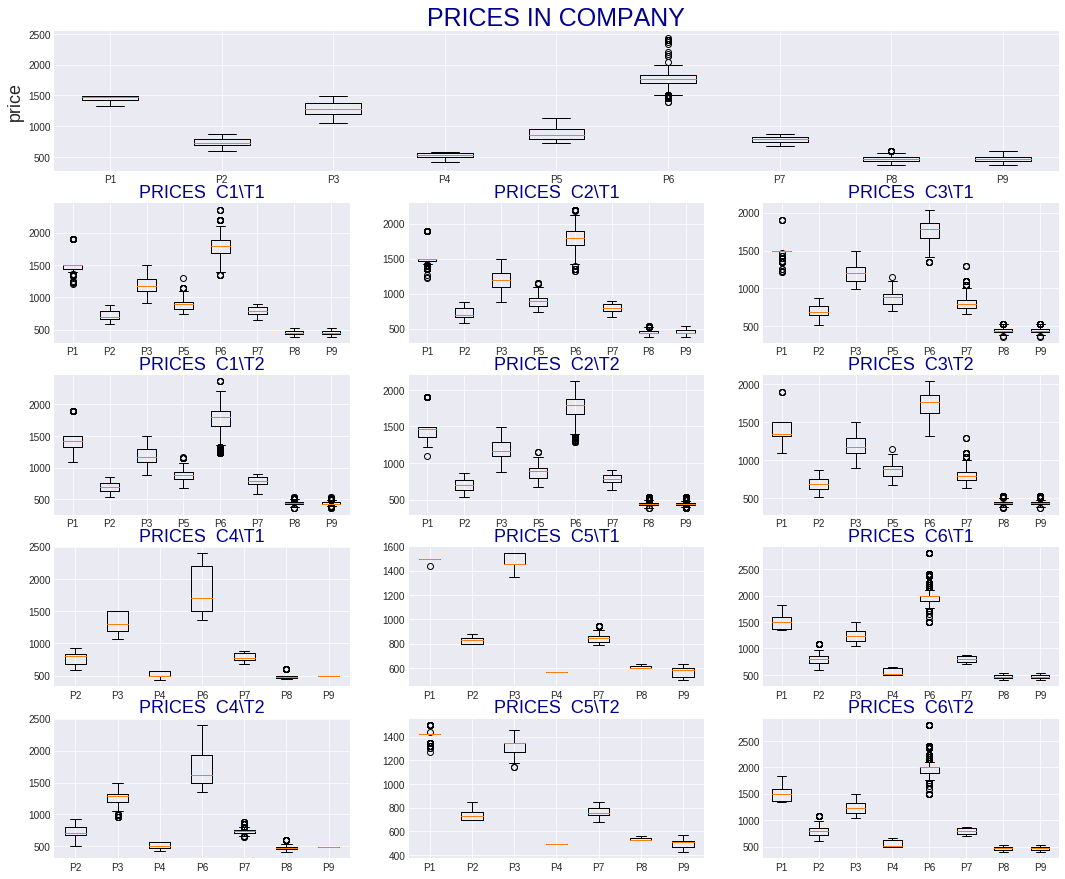

In [6]:
# Prices Dsitribution Plotting

# Style setting
plt.style.use('seaborn-darkgrid') # style

# Grid building

fig = plt.figure(figsize=(18,16))

gs = mpl.gridspec.GridSpec(21,3, wspace=0.2, hspace=3.0)
axli = plt.subplot(gs[:4, :])
ax1 = plt.subplot(gs[4:8, :-2])
ax2 = plt.subplot(gs[4:8, 1:-1])
ax3 = plt.subplot(gs[4:8, 2])
ax4 = plt.subplot(gs[8:12, :-2])
ax5 = plt.subplot(gs[8:12, 1:-1])
ax6 = plt.subplot(gs[8:12, 2])
ax7 = plt.subplot(gs[12:16, :-2])
ax8 = plt.subplot(gs[12:16, 1:-1])
ax9 = plt.subplot(gs[12:16, 2])
ax10 = plt.subplot(gs[16:20, :-2])
ax11 = plt.subplot(gs[16:20, 1:-1])
ax12 = plt.subplot(gs[16:20, 2])

# Parameters
comp = {'C1T1':ax1, 'C2T1':ax2, 'C3T1':ax3, 'C1T2':ax4, 'C2T2':ax5, 'C3T2':ax6,
        'C4T1':ax7, 'C5T1':ax8, 'C6T1':ax9, 'C4T2':ax10, 'C5T2':ax11, 'C6T2':ax12}

# BoxPlot - Total
dados = df_sales.pivot_table(index = 'PROD_ID', columns='DATE_ORDER', 
                     values='PRICE', aggfunc='mean').fillna(0)

d = dados.values

l = []

# Buinding a non zero array from price data
for i in list(range(len(d))):
    
    l.append((dados.index[i], d[i][d[i].nonzero()]))

f = dict(l)


dados_xticks = np.array(list(f.keys()))
dados_values = np.array(list(f.values()))

axli.set_title("PRICES IN COMPANY", fontsize=25, color='darkblue')
axli.boxplot(x=dados_values, labels=dados_xticks)
axli.set_ylabel("price", fontsize=18)

# BoxPlot - Competitors
    
for i in list(comp.keys()):
    
    c = i[0] + i[1]
    t = i[2] + i[3]
    p = int(i[3])
    a = comp.get(i)
    
    dados = df_comp[(df_comp['COMPETITOR']==c) & (df_comp['PAY_TYPE']==p)]\
    .pivot_table(index = 'PROD_ID', columns='DATE_EXTRACTION', 
                         values='COMPETITOR_PRICE', aggfunc='mean').fillna(0)

    d = dados.values

    l = []
    
    # Buinding a non zero array from price data
    for i in list(range(len(d))):

        l.append((dados.index[i], d[i][d[i].nonzero()]))

    f = dict(l)


    dados_xticks = np.array(list(f.keys()))
    dados_values = np.array(list(f.values()))

    a.set_title("PRICES  "+ c + '\\' + t, fontsize=18, color='darkblue')
    a.boxplot(x=dados_values, labels=dados_xticks)

plt.show()

## Correlation Analysis

### Building the base

Our base for analysis will have this schema:

1) 287 lines, corresponding to a day on the period analysed;

2) from sales: each price and each quantity correspond to a feature

3) from competitors: each combination of Price, Payment Type and Competitor is a feature (example Product P1 with Competitor C1 with Payment method 1 is P1C1T1

Our final base, therefore, has 287 lines (date) and 110 features.

In [7]:
# Buinding the dataframe for correlation analysis and machine learning from df_sales

# Grouping and transposing
df_prc = df_sales.pivot_table(index='DATE_ORDER',columns='PROD_ID',values='PRICE').fillna(0)
df_qty = df_sales.pivot_table(index='DATE_ORDER',columns='PROD_ID',values='QTY_ORDER').fillna(0)
df_qty.columns = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9']

# Joinning
df_grp =df_prc.join(df_qty, on='DATE_ORDER',how='left')

In [8]:
# Grouping the features in df_comp and joinning it to df_grp

# Create feature index
df_comp['INDEX'] = df_comp['PROD_ID']+df_comp['COMPETITOR']+ 'T' + df_comp['PAY_TYPE'].apply(lambda x: str(x))

# Grouping and transposing
df_cp = df_comp.pivot_table(index='DATE', columns='INDEX', values='COMPETITOR_PRICE',
                            aggfunc='mean').fillna(0)
# Joinning dataframes
df_grp = df_grp.join(df_cp, how='left')

# Base overview
print(df_grp.shape)
df_grp.head()

(287, 110)


,P1,P2,P3,P4,P5,P6,P7,P8,P9,Q1,...,P9C2T1,P9C2T2,P9C3T1,P9C3T2,P9C4T1,P9C4T2,P9C5T1,P9C5T2,P9C6T1,P9C6T2
DATE_ORDER,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,825.395652,0.0,0.0,0.0,1914.800000,797.315367,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0,827.455682,0.0,0.0,0.0,1914.800000,797.407734,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,0.0,827.780882,0.0,0.0,0.0,1914.800000,796.558216,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,0.0,827.662903,0.0,0.0,0.0,1914.800000,797.350819,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,0.0,823.889474,0.0,0.0,0.0,1909.533333,797.662525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Matrix Overview

Here we make 3 (three) correlation matrix:

1) In Company: plots the prices and sales in quantity of our company;

2) Competitors: plots all competitor's features;

3) Comparison: plots the prices and sales in quantity of our company against competitors's features

In all scenarios, we see a very implicated structure, where many variables are strongly correlated with each other, both positive and negative ways.

On feature selection, we will capture these informations to build a model for each product

###  In Company

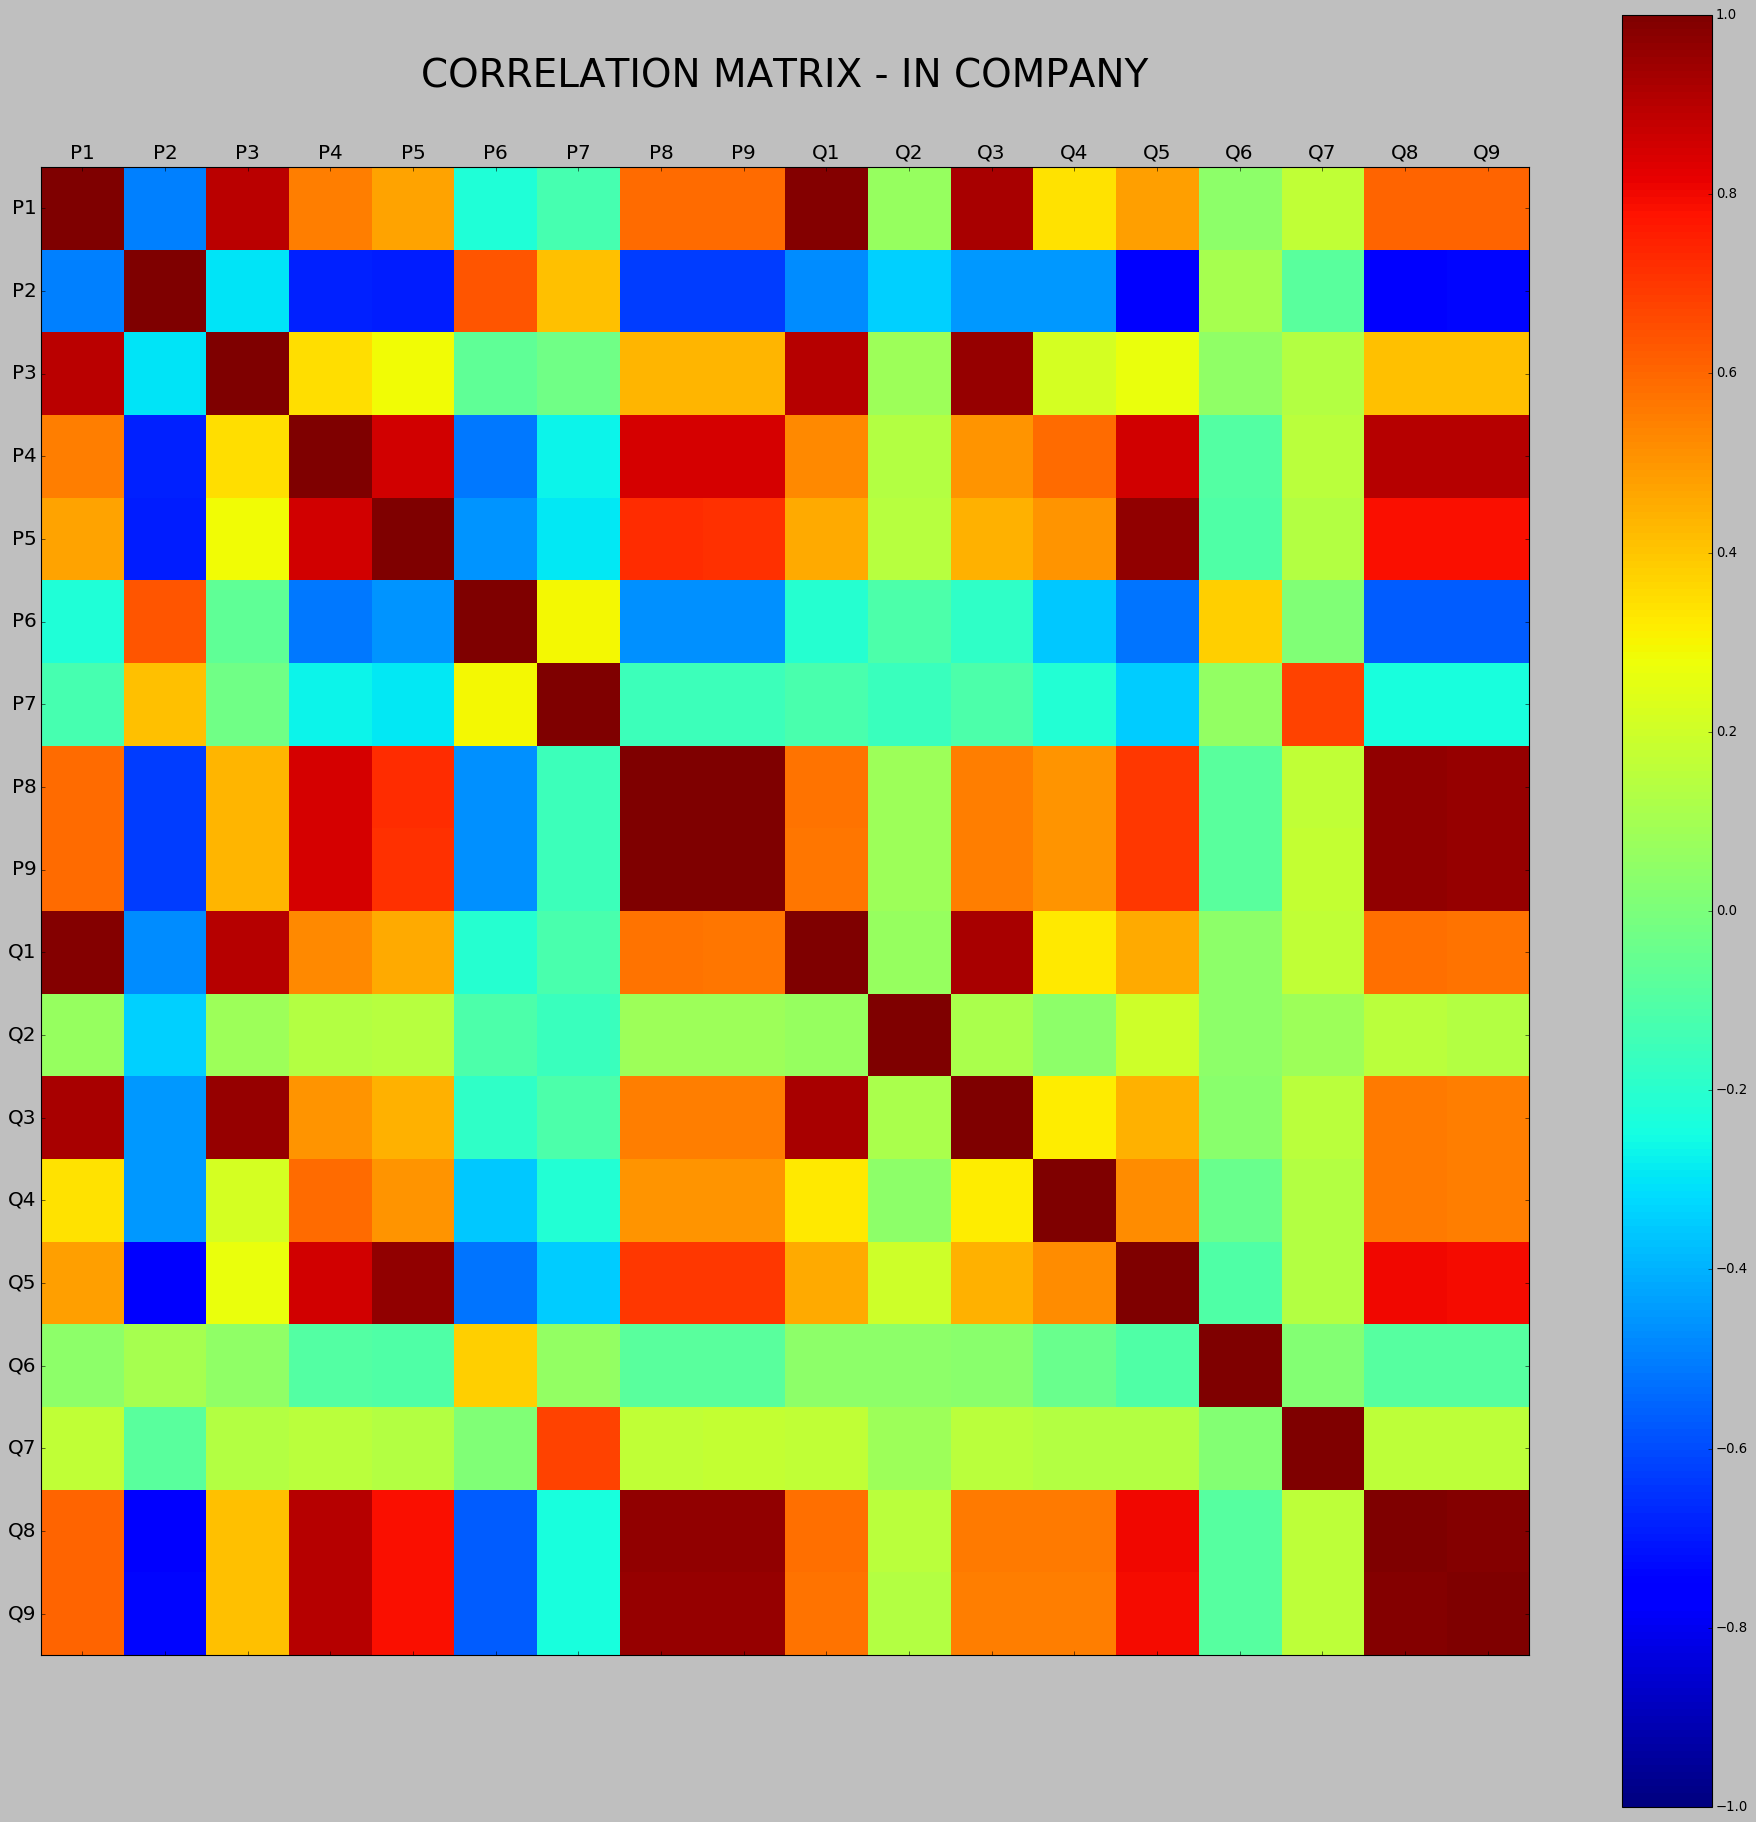

In [9]:
df_corr = df_grp.iloc[:, :18].corr()
correlations = df_corr.values
col = df_grp.iloc[:, :18].columns
plt.style.use('classic')

# Plot da mariz de correlacoes
fig = plt.figure(figsize=(30,28))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 18, 1)
ax.set_title('CORRELATION MATRIX - IN COMPANY', fontsize=35)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(col, fontsize=18)
ax.set_yticklabels(col, fontsize=18)

plt.show()

### Competitors

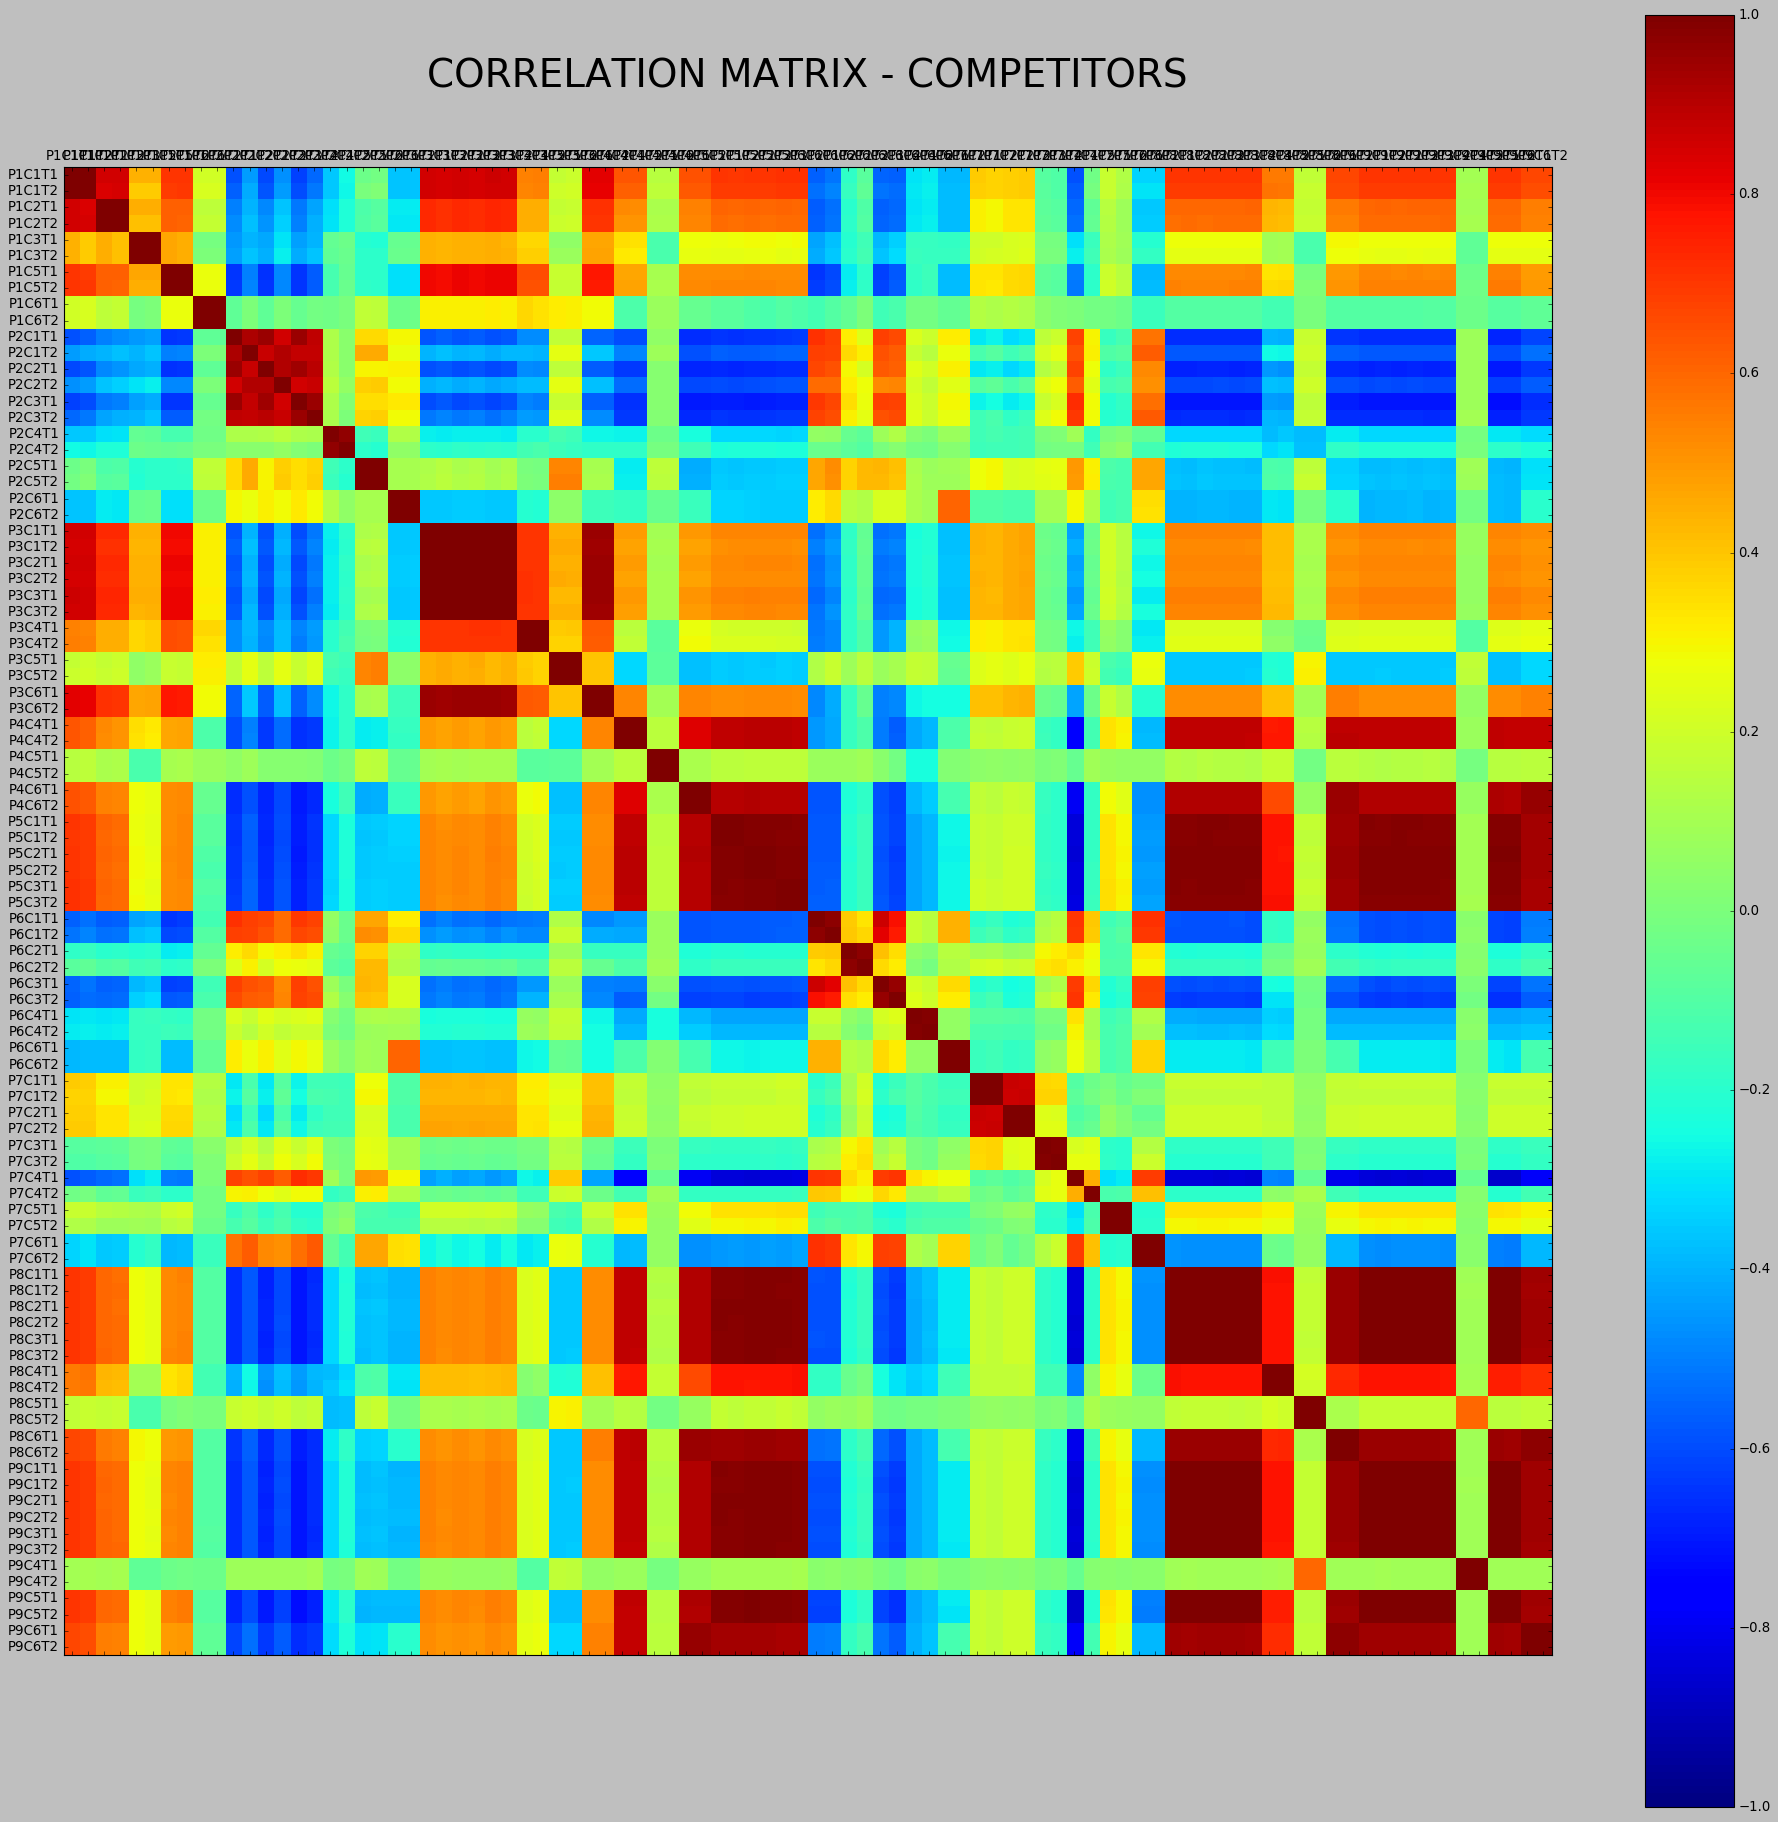

In [10]:
df_corr = df_grp.iloc[:, 18:].corr()
correlations = df_corr.values
col = df_grp.iloc[:, 18:].columns
plt.style.use('classic')

# Plot da mariz de correlacoes
fig = plt.figure(figsize=(30,28))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 92, 1)
ax.set_title('CORRELATION MATRIX - COMPETITORS', fontsize=35)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(col)
ax.set_yticklabels(col)

plt.show()

### Comparison

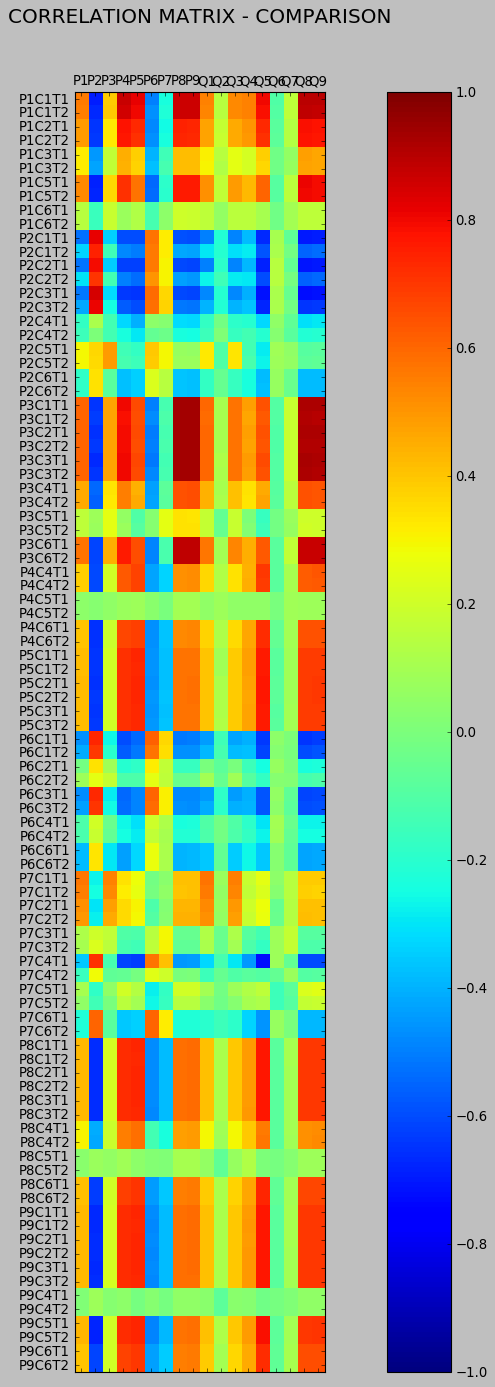

In [11]:
df_corr = df_grp.corr()
correlations = df_corr.iloc[18:, :18].values
xcol = df_corr.iloc[:, :18].columns
ycol = df_corr.iloc[:, 18:].columns
plt.style.use('classic')

# Plot da mariz de correlacoes
fig = plt.figure(figsize=(20,20))
gs = mpl.gridspec.GridSpec(92, 30)
ax = plt.subplot(gs[:, :])
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
xticks = np.arange(0, 18, 1)
yticks = np.arange(0, 92, 1)
ax.set_title('CORRELATION MATRIX - COMPARISON', fontsize=18)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xcol, fontsize=12)
ax.set_yticklabels(ycol)

plt.show()

## Machine Learning

### Feature Selection

For each product, we will only select the features that show a correlation coeficient higher than 0.7 with the product prices or quantities

There are some really important patterns identified here:

1) Products P1 and P3 are only correlated with each other;

2) Products P6 and P7 are not correlated with any other feature

In [12]:
# Parameters
correl_lim = 0.7
num_lim = 9

# Bulding schemas
df_corr = df_grp.corr()
prod_names = []
k = 1

# Feature Selection applying the criteria
while k <= num_lim:
    
    col_sel = []
    name = "prod" + str(k)
    strP = 'P'+str(k)
    strQ = 'Q'+str(k)

    tst = df_corr.loc[[strP,strQ]]

    for i in tst.columns:
        if (abs(tst.iloc[0, :][i]) >= correl_lim or abs(tst.iloc[1, :][i]) >= correl_lim) \
        and i != strP and i != strQ:
            col_sel.append(i)
            
    col_sel.append(strP)
    col_sel.append(strQ)
    
    prod_names.append((name, col_sel))

    k = k + 1

# Building a dictionary with Products (dic.keys) and Features (dic.values)
feature_sel = dict(prod_names)
feature_sel

{'prod1': ['P3', 'Q3', 'P1', 'Q1'],
 'prod2': ['Q5',
  'Q8',
  'Q9',
  'P2C1T1',
  'P2C1T2',
  'P2C2T1',
  'P2C2T2',
  'P2C3T1',
  'P2C3T2',
  'P6C1T1',
  'P6C3T1',
  'P6C3T2',
  'P7C4T1',
  'P2',
  'Q2'],
 'prod3': ['P1', 'Q1', 'P3', 'Q3'],
 'prod4': ['P5',
  'P8',
  'P9',
  'Q5',
  'Q8',
  'Q9',
  'P1C1T1',
  'P1C1T2',
  'P1C2T1',
  'P1C2T2',
  'P1C5T1',
  'P1C5T2',
  'P3C1T1',
  'P3C1T2',
  'P3C2T1',
  'P3C2T2',
  'P3C3T1',
  'P3C3T2',
  'P3C6T1',
  'P3C6T2',
  'P5C1T1',
  'P5C1T2',
  'P5C2T1',
  'P5C2T2',
  'P5C3T1',
  'P5C3T2',
  'P8C1T1',
  'P8C1T2',
  'P8C2T1',
  'P8C2T2',
  'P8C3T1',
  'P8C3T2',
  'P9C1T1',
  'P9C1T2',
  'P9C2T1',
  'P9C2T2',
  'P9C3T1',
  'P9C3T2',
  'P9C5T1',
  'P9C5T2',
  'P4',
  'Q4'],
 'prod5': ['P2',
  'P4',
  'P8',
  'P9',
  'Q8',
  'Q9',
  'P1C1T1',
  'P1C1T2',
  'P1C2T1',
  'P1C2T2',
  'P2C3T1',
  'P4C6T1',
  'P4C6T2',
  'P5C1T1',
  'P5C1T2',
  'P5C2T1',
  'P5C2T2',
  'P5C3T1',
  'P5C3T2',
  'P7C4T1',
  'P8C1T1',
  'P8C1T2',
  'P8C2T1',
  'P8C2T2',
  '

### Machine Learning Process

First, we create a function to iterate on the products features dictionary, prepare the arrays and apply the regressor algorithm

In [13]:
# Function to apply the machine learning process
def fit_model(x, date_cap, model):
    
    report = []

    for prod in list(feature_sel.keys()):

        df_prod = x[feature_sel.get(prod)].reset_index()
        
        # Arrays
        X_train = df_prod[df_prod['DATE_ORDER']<date_cap].iloc[:, 1:-1].fillna(0).values
        Y_train = df_prod[df_prod['DATE_ORDER']<date_cap].iloc[:, -1:].fillna(0).values
        X_test = df_prod[df_prod['DATE_ORDER']>=date_cap].iloc[:, 1:-1].fillna(0).values
        Y_test = df_prod[df_prod['DATE_ORDER']>=date_cap].iloc[:, -1:].fillna(0).values
        
        # Model fit and predict
        model_fit = model.fit(X_train, Y_train)
        Y_pred = model_fit.predict(X_test)
        
        # Evaluation
        rmse = sqrt(mean_squared_error(Y_test, Y_pred))
        
        # Result: a dic with all process inputs and outputs 
        report.append((prod,(model_fit, X_train, Y_train, X_test, Y_test,Y_pred, rmse)))

    return dict(report)
    

Then, we can implement a model testing process.

Using Root Mean Squared Error (RMSE) and it's relavance on the QTY Mean, we can select, for each product, the algorithm that achieved the lowest error.

There are some issu with product P4 that has to be handled later, for it did not fit efectivelly with any algorithm applied.

In [14]:
# Model Selection
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()
svr = SVR()
ens = RandomForestRegressor()
xgb = XGBRegressor()

models = {'KNN': knn, 'DECISION_TREE': tree, 
          'SVR': svr, 'RANDOM_FOREST': ens, 'XGBOOST': xgb}

d = dt.date(2015,8,1)

print("MODEL SELECTION \n")

for t in list(models.keys()):
    
    m = models.get(t)
    dic = fit_model(x=df_grp, date_cap=d, model=m)
    print("MODEL: ", t, "\n")
    
    for k in list(dic.keys()):
        print(k, ":", "rmse: %.3f \t QTY_mean: %.3f \t rmse_perc: %.1f%%" % 
              (dic.get(k)[6], dic.get(k)[4].mean(), dic.get(k)[6]/dic.get(k)[4].mean()*100))
    
    print('\n')

MODEL SELECTION 

MODEL:  KNN 

prod1 : rmse: 0.047 	 QTY_mean: 1.003 	 rmse_perc: 4.7%
prod2 : rmse: 0.066 	 QTY_mean: 1.054 	 rmse_perc: 6.3%
prod3 : rmse: 0.239 	 QTY_mean: 0.972 	 rmse_perc: 24.6%
prod4 : rmse: 1.339 	 QTY_mean: 1.243 	 rmse_perc: 107.7%
prod5 : rmse: 0.134 	 QTY_mean: 1.044 	 rmse_perc: 12.9%
prod6 : rmse: 0.137 	 QTY_mean: 1.012 	 rmse_perc: 13.5%
prod7 : rmse: 0.053 	 QTY_mean: 1.057 	 rmse_perc: 5.0%
prod8 : rmse: 0.135 	 QTY_mean: 1.059 	 rmse_perc: 12.7%
prod9 : rmse: 0.142 	 QTY_mean: 1.059 	 rmse_perc: 13.4%


MODEL:  DECISION_TREE 

prod1 : rmse: 0.051 	 QTY_mean: 1.003 	 rmse_perc: 5.1%
prod2 : rmse: 0.071 	 QTY_mean: 1.054 	 rmse_perc: 6.7%
prod3 : rmse: 0.054 	 QTY_mean: 0.972 	 rmse_perc: 5.6%
prod4 : rmse: 1.675 	 QTY_mean: 1.243 	 rmse_perc: 134.7%
prod5 : rmse: 0.360 	 QTY_mean: 1.044 	 rmse_perc: 34.5%
prod6 : rmse: 0.137 	 QTY_mean: 1.012 	 rmse_perc: 13.6%
prod7 : rmse: 0.059 	 QTY_mean: 1.057 	 rmse_perc: 5.6%
prod8 : rmse: 0.078 	 QTY_mean: 1.0

# End